In [1]:
import os

In [2]:
%pwd

'd:\\iNeuron_Projects\\End_to_End_ML_Dental_Implant_Sandblasting\\research'

In [3]:
os.chdir("../")

In [4]:
%pwd

'd:\\iNeuron_Projects\\End_to_End_ML_Dental_Implant_Sandblasting'

[2024-10-04 23:55:16,394: INFO: 585829489: >>>>> Stage 05: Model Evaluation Execution Started <<<<<]
[2024-10-04 23:55:16,410: INFO: common: yaml file: config\config.yaml loaded successfully]
[2024-10-04 23:55:16,432: INFO: common: yaml file: params.yaml loaded successfully]
[2024-10-04 23:55:16,435: INFO: common: created directory at: artifacts]
[2024-10-04 23:55:16,438: INFO: common: created directory at: artifacts/model_evaluation]
[2024-10-04 23:55:20,106: INFO: 585829489: 
Evaluation metrics for RandomForest (Sa):]
[2024-10-04 23:55:20,108: INFO: 585829489: MAE: 0.6823, MSE: 0.7075, R²: -0.1860, MAPE: 430.7847%, SMAPE: 154.4496%]
[2024-10-04 23:55:20,115: INFO: 585829489: 
Evaluation metrics for Ridge (Sa):]
[2024-10-04 23:55:20,116: INFO: 585829489: MAE: 0.6524, MSE: 0.6250, R²: -0.0477, MAPE: 184.1209%, SMAPE: 188.0993%]
[2024-10-04 23:55:20,126: INFO: 585829489: 
Evaluation metrics for BaggingRF (CV):]
[2024-10-04 23:55:20,127: INFO: 585829489: MAE: 0.6544, MSE: 0.6538, R²: -0.

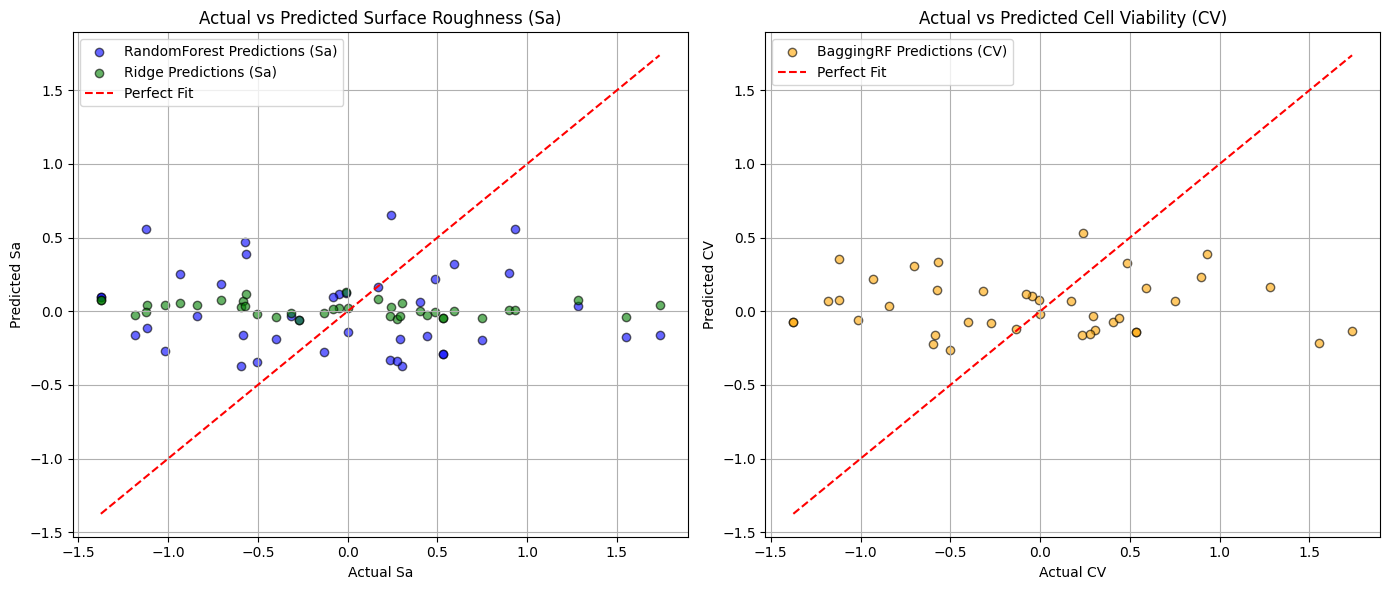

[2024-10-04 23:55:21,020: INFO: common: json file saved at: artifacts\model_evaluation\evaluation_results.json]
[2024-10-04 23:55:21,085: INFO: 585829489: >>>>> Stage 05: Model Evaluation Execution Completed <<<<<]


In [5]:
# Import necessary libraries
import os  # For handling file paths and operations
import json  # For saving final prediction results
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import urlparse  # For URL handling in future stages
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.linear_model import Ridge
import joblib  # Used for saving/loading models
from dataclasses import dataclass
from pathlib import Path
from Dental_Implant_Sandblasting.utils.common import read_yaml, create_directories, save_json  # Added save_json
from Dental_Implant_Sandblasting.constants import CONFIG_FILE_PATH, PARAMS_FILE_PATH, SCHEMA_FILE_PATH  # Added SCHEMA_FILE_PATH
from Dental_Implant_Sandblasting import logger

# Step 1: Define the data class for configuration
@dataclass(frozen=True)
class ModelEvaluationConfig:
    root_dir: Path
    model_dir: Path
    test_sa_data: Path
    test_cv_data: Path
    n_estimators_rf: int
    max_depth_rf: int
    min_samples_split_rf: int
    min_samples_leaf_rf: int
    bootstrap_rf: bool
    alpha_ridge: float
    n_estimators_bagging: int
    max_samples_bagging: float
    max_features_bagging: float
    random_state: int

# Step 2: Configuration Manager to load parameters from YAML
class ConfigurationManager:
    def __init__(self, config_filepath=CONFIG_FILE_PATH, params_filepath=PARAMS_FILE_PATH):
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        create_directories([self.config['artifacts_root']])

    def get_model_evaluation_config(self) -> ModelEvaluationConfig:
        config = self.config['model_evaluation']
        params = self.params['model_evaluation']
        create_directories([config['root_dir']])
        
        model_evaluation_config = ModelEvaluationConfig(
            root_dir=Path(config['root_dir']),
            model_dir=Path(config['model_dir']),
            test_sa_data=Path(config['test_sa_data']),
            test_cv_data=Path(config['test_cv_data']),
            n_estimators_rf=params['n_estimators_rf'],
            max_depth_rf=params['max_depth_rf'],
            min_samples_split_rf=params['min_samples_split_rf'],
            min_samples_leaf_rf=params['min_samples_leaf_rf'],
            bootstrap_rf=params['bootstrap_rf'],
            alpha_ridge=params['alpha_ridge'],
            n_estimators_bagging=params['n_estimators_bagging'],
            max_samples_bagging=params['max_samples_bagging'],
            max_features_bagging=params['max_features_bagging'],
            random_state=params['random_state']
        )
        return model_evaluation_config

# Step 3: Model Evaluation class
class ModelEvaluation:
    def __init__(self, config: ModelEvaluationConfig):
        self.config = config

    def load_data(self):
        # Load test datasets for Surface Roughness (Sa) and Cell Viability (CV)
        X_test_sa = pd.read_csv(self.config.test_sa_data).iloc[:, :-1]
        y_test_sa = pd.read_csv(self.config.test_sa_data).iloc[:, -1]
        X_test_cv = pd.read_csv(self.config.test_cv_data).iloc[:, :-1]
        y_test_cv = pd.read_csv(self.config.test_cv_data).iloc[:, -1]
        
        return (X_test_sa, y_test_sa), (X_test_cv, y_test_cv)

    def load_models(self):
        # Load the best models saved from previous stages
        rf_model_sa = joblib.load(self.config.model_dir / "best_rf_model_sa.joblib")
        ridge_model_sa = joblib.load(self.config.model_dir / "best_ridge_model_sa.joblib")
        bagging_model_cv = joblib.load(self.config.model_dir / "best_rf_model_cv.joblib")

        return rf_model_sa, ridge_model_sa, bagging_model_cv

    # Evaluation function
    def evaluate_model(self, y_true, y_pred, model_name):
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        smape = 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true) + 1e-10))

        logger.info(f"\nEvaluation metrics for {model_name}:")
        logger.info(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R²: {r2:.4f}, MAPE: {mape:.4f}%, SMAPE: {smape:.4f}%")

        return mae, mse, r2, mape, smape

    # Visualizations function
    def visualize_results(self, y_test_sa, y_sa_pred_rf, y_sa_pred_ridge, y_test_cv, y_cv_pred_bagging):
        # Predicted vs Actual Values Plot
        plt.figure(figsize=(14, 6))
        plt.subplot(1, 2, 1)
        plt.scatter(y_test_sa, y_sa_pred_rf, alpha=0.6, label="RandomForest Predictions (Sa)", color="blue", edgecolors="k")
        plt.scatter(y_test_sa, y_sa_pred_ridge, alpha=0.6, label="Ridge Predictions (Sa)", color="green", edgecolors="k")
        plt.plot([y_test_sa.min(), y_test_sa.max()], [y_test_sa.min(), y_test_sa.max()], color="red", linestyle="--", label="Perfect Fit")
        plt.title("Actual vs Predicted Surface Roughness (Sa)")
        plt.xlabel("Actual Sa")
        plt.ylabel("Predicted Sa")
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.scatter(y_test_cv, y_cv_pred_bagging, alpha=0.6, label="BaggingRF Predictions (CV)", color="orange", edgecolors="k")
        plt.plot([y_test_cv.min(), y_test_cv.max()], [y_test_cv.min(), y_test_cv.max()], color="red", linestyle="--", label="Perfect Fit")
        plt.title("Actual vs Predicted Cell Viability (CV)")
        plt.xlabel("Actual CV")
        plt.ylabel("Predicted CV")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Execute the evaluation
    def execute(self):
        try:
            # Load data
            (X_test_sa, y_test_sa), (X_test_cv, y_test_cv) = self.load_data()

            # Load models
            rf_model_sa, ridge_model_sa, bagging_model_cv = self.load_models()

            # Make predictions
            y_sa_pred_rf = rf_model_sa.predict(X_test_sa)
            y_sa_pred_ridge = ridge_model_sa.predict(X_test_sa)
            y_cv_pred_bagging = bagging_model_cv.predict(X_test_cv)

            # Evaluate models
            self.evaluate_model(y_test_sa, y_sa_pred_rf, "RandomForest (Sa)")
            self.evaluate_model(y_test_sa, y_sa_pred_ridge, "Ridge (Sa)")
            self.evaluate_model(y_test_cv, y_cv_pred_bagging, "BaggingRF (CV)")

            # Visualize the results
            self.visualize_results(y_test_sa, y_sa_pred_rf, y_sa_pred_ridge, y_test_cv, y_cv_pred_bagging)

            # Saving predictions in JSON format (optional for web interface)
            results = {
                "y_sa_pred_rf": y_sa_pred_rf.tolist(),
                "y_sa_pred_ridge": y_sa_pred_ridge.tolist(),
                "y_cv_pred_bagging": y_cv_pred_bagging.tolist()
            }
            save_json(self.config.root_dir / "evaluation_results.json", results)  # Save predictions in JSON format

        except Exception as e:
            logger.exception(e)
            raise e

# Step 4: Pipeline Execution
try:
    logger.info(">>>>> Stage 05: Model Evaluation Execution Started <<<<<")
    config = ConfigurationManager()
    model_evaluation_config = config.get_model_evaluation_config()
    model_evaluation = ModelEvaluation(config=model_evaluation_config)
    model_evaluation.execute()
    logger.info(">>>>> Stage 05: Model Evaluation Execution Completed <<<<<")
except Exception as e:
    logger.exception(e)
    raise e
